In [7]:
import torch
import os

In [10]:
prompt_file = 'gen_prompt_actions'
embeddings_paths = {}
embeddings_paths['celebA_342_db_lora_lr1e-4_rank4_train_text_encoder'] = 'embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/{}/{}/prompt_embeddings.pt'

reference_embedding_path = 'embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/{}/50/reference_embeddings.pt'.format(prompt_file)

embeddings = {}
for exp_name in embeddings_paths.keys():
    embeddings[exp_name] = {}
    for step in range(4000):
        path = embeddings_paths[exp_name].format(prompt_file, step)
        if os.path.exists(path):
            embeddings[exp_name][step] = torch.load(path)
            print(path, embeddings[exp_name][step].shape)

reference_embedding = torch.load(reference_embedding_path)

embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/gen_prompt_actions/50/prompt_embeddings.pt torch.Size([17, 77, 768])
embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/gen_prompt_actions/100/prompt_embeddings.pt torch.Size([17, 77, 768])
embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/gen_prompt_actions/150/prompt_embeddings.pt torch.Size([17, 77, 768])
embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/gen_prompt_actions/200/prompt_embeddings.pt torch.Size([17, 77, 768])
embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/gen_prompt_actions/300/prompt_embeddings.pt torch.Size([17, 77, 768])
embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/gen_prompt_actions/400/prompt_embeddings.pt torch.Size([17, 77, 768])
embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/gen_prompt_actions/600/prompt_embeddings.pt torch.Size([17, 77, 768])
embeddings/celebA_342_db_lora_lr1e-4_rank4_train_text_encoder/gen_prompt_acti

/tmp/ipykernel_2440059/4207025556.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings[exp_name][step] = torch.load(path)
/tmp/ipykernel_2440059/4207025556.py:16:

In [13]:
for exp_name in embeddings.keys():
    for step in embeddings[exp_name].keys():
        print(embeddings[exp_name][step].shape, torch.norm(embeddings[exp_name][step][:,-1,:]),torch.norm(embeddings[exp_name][step] - reference_embedding), torch.norm(embeddings[exp_name][step][:,-1,:] - reference_embedding[:,-1,:]))


torch.Size([17, 77, 768]) tensor(114.7971, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(246.9968, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(25.8676, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
torch.Size([17, 77, 768]) tensor(114.3773, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(280.0493, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(28.8121, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
torch.Size([17, 77, 768]) tensor(114.1864, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(328.8544, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(34.1512, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
torch.Size([17, 77, 768]) tensor(114.3787, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(359.9397, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(37.6901, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
torch.Size([17, 77, 768]) tensor(114.5467, devic

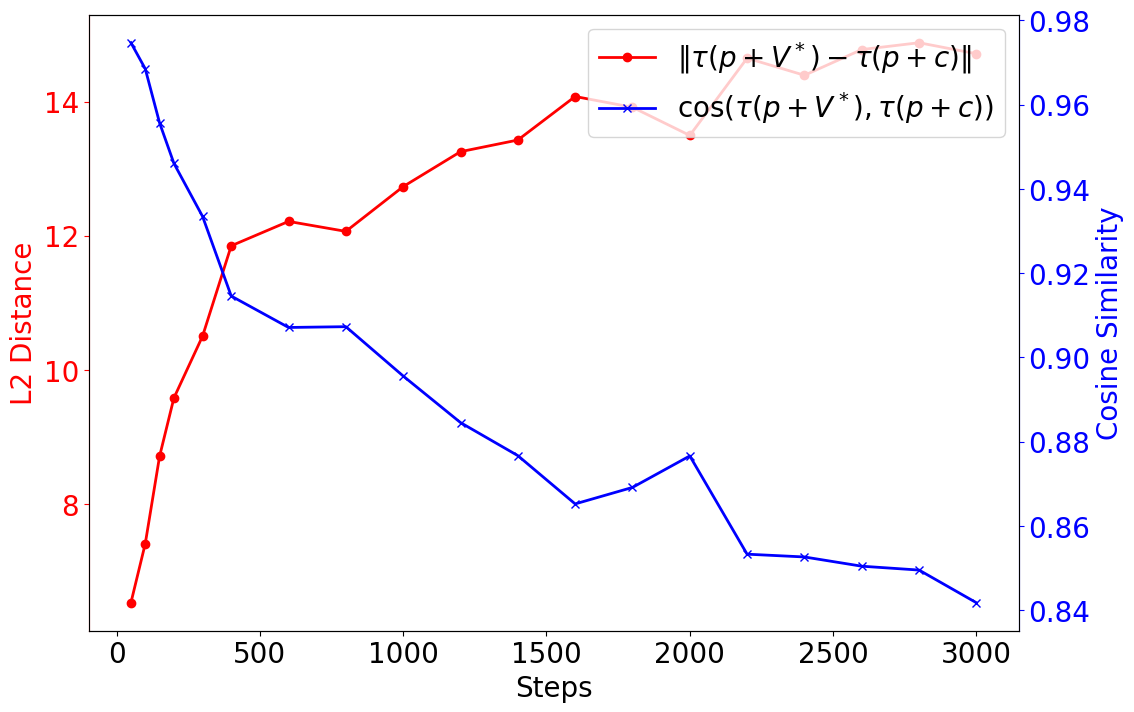

In [28]:
# plot the embedding drift
# plot the diff norm between the reference embedding and the current embedding over time 
import matplotlib.pyplot as plt

fontsize = 20
line_width = 2

# Create a figure for the embedding drift plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Set colors for axes
ax1.spines['left'].set_color('red')
ax1.spines['right'].set_color('blue')
ax1.tick_params(axis='y', colors='red', labelsize=fontsize)
ax2.tick_params(axis='y', colors='blue', labelsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)

# Plot the difference norm between reference and current embeddings
for exp_name in embeddings.keys():
    diff_norms = []
    cos_sims = []
    steps = list(embeddings[exp_name].keys())
    steps.sort()
    for step in steps:
        diff_norms.append((torch.mean(torch.norm(embeddings[exp_name][step] - reference_embedding, dim=-1))).item())
        cos_sim = torch.nn.functional.cosine_similarity(embeddings[exp_name][step][:,-1,:], reference_embedding[:,-1,:])
        cos_sims.append(torch.mean(cos_sim).item())

    # Plot diff_norms on the first y-axis
    line1 = ax1.plot(steps, diff_norms, color='red', label=r'$\| \tau(p+V^*) - \tau(p+c) \|$',  marker='o', linewidth=line_width)
    # Plot cos_sims on the second y-axis
    line2 = ax2.plot(steps, cos_sims, color='blue', label=r'$\cos(\tau(p+V^*), \tau(p+c))$',  marker='x', linewidth=line_width)

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=fontsize)

# Set labels for axes
ax1.set_xlabel('Steps', fontsize=fontsize)
ax1.set_ylabel('L2 Distance', fontsize=fontsize, color='red')
ax2.set_ylabel('Cosine Similarity', fontsize=fontsize, color='blue')

# plt.show()
plt.savefig('results/db_lora_semantic_drift_{}.png'.format(prompt_file), dpi=300)
    



